# Visual SLAM

In this notebook we will implement a visual SLAM including an OpenCV frontend, a GTSAM backend and a loop closure module using DBOW3 (fBOW).

We will test our SLAM system with abadoned_factory P006 (108-505) sequence in [TartanAir dataset](http://theairlab.org/tartanair-dataset/). The camera intrinsics, extrinsics and data format can be found [here](https://github.com/castacks/tartanair_tools/blob/master/data_type.md).

## steps
- steps
- visualization

## I. Dependency

todo: provide a pip command here

In [27]:
!pip install ..

/home/link/miniconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Processing /home/link/Projects/minimum-slam
  Preparing metadata (setup.py) ... done
  Created wheel for minslam: filename=minslam-0.0.1-py3-none-any.whl size=7659 sha256=4cf5f06a9dd33b7f9d6d6a4a809faae509391178b65ead4c973e496479701f4c
  Stored in directory: /home/link/.cache/pip/wheels/3d/8f/99/13faf0722de10103e6720bb87110787d0676ea1654ff6b8120
Successfully built minslam
  Attempting uninstall: minslam
    Found existing installation: minslam 0.0.1
    Uninstalling minslam-0.0.1:
      Successfully uninstalled minslam-0.0.1


In [28]:
# frontend
import numpy as np
from spatialmath import *
import cv2
import matplotlib.pyplot as plt

# our slam implementation
from minslam.data_loader import TartanAirLoader
from minslam.frontend import Frontend
from minslam.params import Params

In [29]:
# backend
import os
import gtsam
from gtsam.symbol_shorthand import L, X
import numpy as np
from scipy.spatial.transform import Rotation as R # replace with spatialmath
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass

## II. Frontend

### 1. Load images and trajectory

Loading trajectory from  ../data/pose_left.txt
First 3 lines of TartanAir trajectory file:
5.246845722198486328e+00 -2.774246215820312500e+01 -3.012477874755859375e+00 1.602893229573965073e-03 -3.144130408763885498e-01 1.141050923615694046e-02 9.492163062095642090e-01
5.005289077758789062e+00 -2.763811683654785156e+01 -2.977025032043457031e+00 9.657302871346473694e-03 -3.079342246055603027e-01 2.714120037853717804e-02 9.509713649749755859e-01
4.765544414520263672e+00 -2.753191375732421875e+01 -2.936581373214721680e+00 1.755466312170028687e-02 -3.009457886219024658e-01 4.383775591850280762e-02 9.524713158607482910e-01

First 3 SE3 poses:
[0] =
   0.802    -0.02267  -0.5969    5.247     
   0.02065   0.9997   -0.01022  -27.74     
   0.5969   -0.004132  0.8023   -3.012     
   0         0         0         1         
[1] =
   0.8089   -0.05757  -0.5851    5.005     
   0.04567   0.9983   -0.03508  -27.64     
   0.5862    0.001652  0.8102   -2.977     
   0         0         0         1 

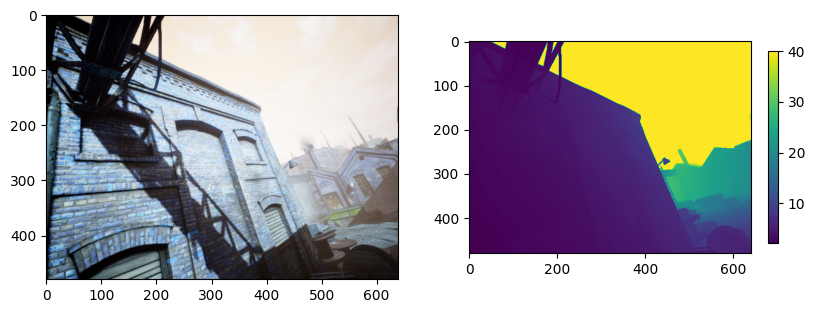

In [30]:
dataset_folder = '../data/'
traj_filename = 'pose_left.txt'
traj_path = os.path.join(dataset_folder, traj_filename)
print('Loading trajectory from ', traj_path)

# Have a look at the trajectory file
print('First 3 lines of TartanAir trajectory file:')
with open(traj_path, 'r') as f:
    print(''.join(f.readlines()[:3])) # tx ty tz qx qy qz qw

# load a trajectory
print('First 3 SE3 poses:')
dataset = TartanAirLoader(dataset_folder)
gt_traj = dataset._load_traj('tum', traj_filename, add_timestamps=True)
print(gt_traj[:3])

# set the gt as odom for testing
dataset.set_ground_truth(gt_traj)
dataset.set_odometry(gt_traj)

# load the first frame
dataset.set_curr_index(50)
color, depth = dataset.read_current_rgbd()

# show color and depth horizontally
print('color image data type:', color.dtype)
print('depth image data type:', depth.dtype)
print('depth image range:', f'{depth.min()} - {depth.max()}')
axes = plt.subplots(1, 2, figsize=(10, 5))[1]
axes[0].imshow(color)
axes[1].imshow(depth.clip(0,40))
# colorbar height equal to image height
axes[1].figure.colorbar(axes[1].images[0], ax=axes[1], shrink=0.5)
plt.show()

### 2. Keyframe selection

todo: formula, why

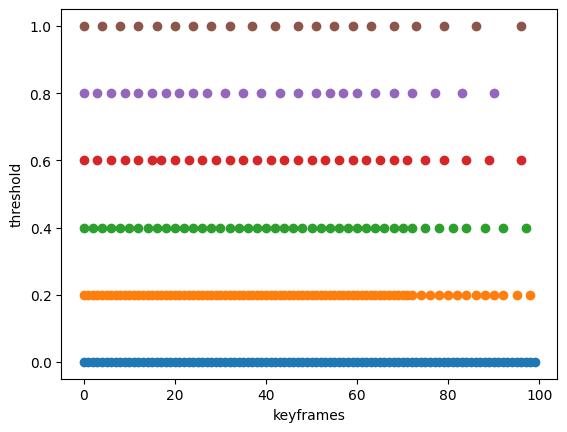

In [8]:
# intialize our frontend implementation
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)

# The keyframe_selection function accepts a pose and returns a boolean.
# The first frame is always a keyframe, then we check if the motion is
# large enough.
pose = dataset.read_current_odometry()
is_keyframe = frontend.keyframe_selection(pose)

# What if we set the threshold to different values?
is_keyframe_dict = {}
for threshold in np.arange(0, 1.1, 0.2):
    frontend.params['frontend']['keyframe']['threshold'] = threshold
    is_keyframe_dict[threshold] = np.zeros(100)
    for i in range(100):
        dataset.set_curr_index(i)
        pose = dataset.read_current_odometry()
        is_keyframe_dict[threshold][i] = frontend.keyframe_selection(pose)
        if is_keyframe_dict[threshold][i]:
            frontend.add_keyframe(pose, color, depth)
    plt.scatter(np.arange(100), np.where(is_keyframe_dict[threshold]==1, threshold, None), label=f'threshold={threshold}')
plt.xlabel('keyframes')
plt.ylabel('threshold')
plt.show()

### 3. Extract features and generate matches

sift + optical flow method

https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html

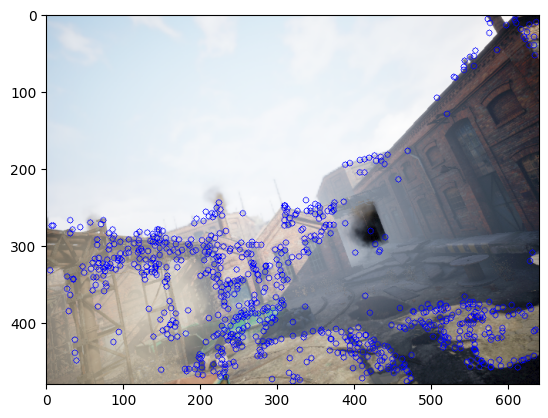

In [9]:
# clear previous states
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)

# add a keyframe
dataset.set_curr_index(100)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)

# extract features
frontend.extract_features()
frontend.plot_features()

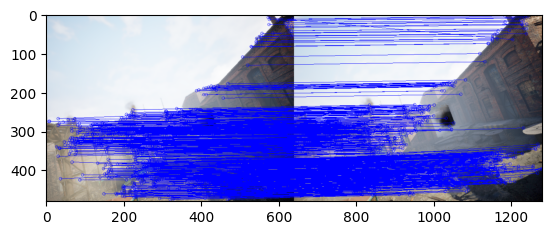

In [10]:
# add another keyframe
dataset.set_curr_index(105)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)

# match features
frontend.match_features()
frontend.plot_matches()

### 4. Remove match outliers
fundenmantal matrix ransac (opencv implementation)

number of matches before outlier rejection: 858


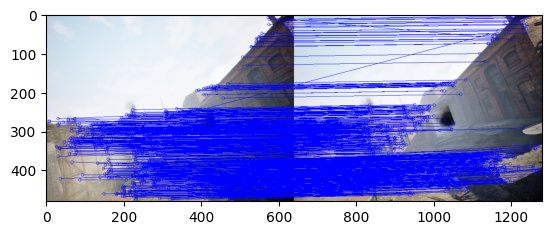

In [11]:
# to test whether the algorithm works, we manually add a wrong match here
frontend.curr_frame.points.append(np.array([500,50], dtype=np.float32))
frontend.curr_frame.matches.append(cv2.DMatch(100, len(frontend.curr_frame.points)-1, 0))
frontend.plot_matches()
print('number of matches before outlier rejection:', len(frontend.curr_frame.matches))

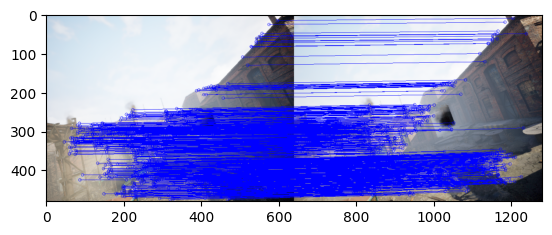

In [12]:
# after removing outliers, the wrong match we added should be removed
frontend.eliminate_outliers()
frontend.plot_matches()

### 5. Assign global ID

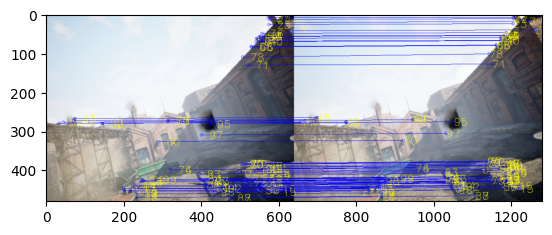

In [17]:
# clear previous states
params = Params('../params/tartanair.yaml')
# we lower the feature number to make the plot easier to read
params['frontend']['feature']['number'] = 100
frontend = Frontend(params)

# add a keyframe
dataset.set_curr_index(100)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)
frontend.extract_features()
frontend.assign_global_id()

# add another keyframe
dataset.set_curr_index(102)
pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)
frontend.extract_features()
frontend.match_features()
frontend.eliminate_outliers()
frontend.assign_global_id()

frontend.plot_matches(with_global_id=True)

### 6. Test the frontend

In [31]:
# clear previous states
params = Params('../params/tartanair.yaml')
frontend = Frontend(params)
dataset.set_curr_index(100)

--- Added keyframe 9 (seq id: 142) ---


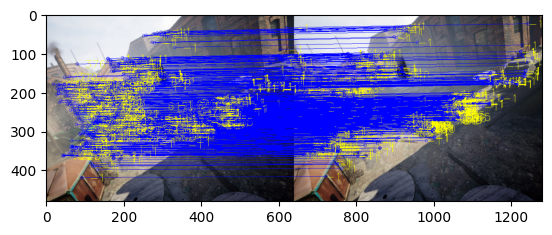

In [41]:
# run this block multiple times to add more keyframes
pose = dataset.read_current_odometry()
while not frontend.keyframe_selection(pose):
    if not dataset.load_next_frame():
        break
    pose = dataset.read_current_odometry()
color, depth = dataset.read_current_rgbd()
frontend.add_keyframe(pose, color, depth)
print(f'--- Added keyframe {frontend.frame_id} (seq id: {dataset.curr_index}) ---')
if frontend.frame_id > 0:
    frontend.match_features()
frontend.extract_features(params['frontend']['feature']['number']-len(frontend.curr_frame.points), append_mode=True)
frontend.eliminate_outliers()
frontend.assign_global_id()
frontend.plot_matches(with_global_id=True)

## III. Backend

We will build a backend similar to ORB-SLAM2.

local BA (points from recent covisible keyframes ) + global BA (full optimization or pose graph)

### 4. Calculate global position of landmarks



(pinhole camera model, global id)

### Map

### 1. Build the graph


### 2. Optimize

### 3. Backend Class

## IV. Loop Closure
Basically a pyhton version of https://github.com/nicolov/simple_slam_loop_closure/blob/master/src/new_college.cpp

### 1. FBoW
https://github.com/vik748/pyfbow
or: https://github.com/foxis/pyDBoW3

### 2. Global BA